# Problem 1

In [1]:
#Solve for the steady-state in 3-per OG model

#Import libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
%matplotlib inline

#Household parameters
nvec = np.array([1.0,1.0,0.2])
yrs_live = 60
S = 3.0
beta_annual = 0.96
beta = beta_annual ** (yrs_live / S)
sigma = 3.

#Firm's parameters
alpha = 0.35
A = 1.0
delta_annual = 0.05
delta = 1 - (1.-delta_annual)**(yrs_live/S)
 
#Initialize functions which will be used later in the code
def rfunc(K, L, params):
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1-alpha)) - delta
    return r

def wfunc(K, L, params):
    A, alpha = params
    w = (1 - alpha) * A * ((K / L) ** alpha)
    return w

def muc1(n, w, r, b2, sigma):
    c1 = n * w - b2
    return c1 ** (-1. * sigma)

def muc2(n, w, r, b2, b3, sigma):
    c2 = n * w + (1. + r) * b2 - b3
    return c2 ** (-1. * sigma)
    
def muc3(n, w, r, b2, b3, sigma):
    c3 = n * w + (1. + r) * b3
    return c3 ** (-1. * sigma)
    
#Calculate the steady state equilibrium by using a root finder of the Euler errors
    
def steady_state(b2b3, args):
    beta, sigma, alpha, A, delta, nvec = args
    b2, b3 = b2b3
    K = np.sum(b2b3)
    L = np.sum(nvec)
    w = wfunc(K, L, (A, alpha))
    r = rfunc(K, L, (A, alpha, delta))
    MUc1 = muc1(nvec[0], w, r, b2, sigma)
    MUc2 = muc2(nvec[1], w, r, b2, b3, sigma)
    MUc3 = muc3(nvec[2], w, r, b2, b3, sigma)
    error1 = MUc1 - beta * (1.+r) * MUc2
    error2 = MUc2 - beta * (1.+r) * MUc3
    return np.array([error1, error2])
    

sol = opt.root(steady_state, np.array([.1,.1]), \
               args = [beta, sigma, alpha, A, delta, nvec])

In [2]:
b2_bar, b3_bar = sol['x']
K = np.sum(sol['x'])
L = np.sum(nvec)
w_bar = (1 - alpha) * A * ((K / L) ** alpha)
r_bar = alpha * A * ((L / K) ** (1-alpha)) - delta
c1 = nvec[0] * w_bar - b2_bar
c2 = nvec[1] * w_bar + (1. + r_bar) * b2_bar - b3_bar
c3 = nvec[2] * w_bar + (1. + r_bar) * b3_bar
print "Using annual beta = {}, results are as follows:".format(beta_annual)
print "c1 = {}".format(c1)
print "c2 = {}".format(c2)
print "c3 = {}".format(c3)
print "b2 = {}".format(b2_bar)
print "b3 = {}".format(b3_bar)
print "w = {}".format(w_bar)
print "r = {}\n\n".format(r_bar)

Using annual beta = 0.96, results are as follows:
c1 = 0.182412558356
c2 = 0.209614907072
c3 = 0.240873817365
b2 = 0.0193127352392
b3 = 0.058411590879
w = 0.201725293596
r = 2.43303025356




# Problem 2

Problem 2 is an extension of problem one. In order to see the effects of an increase in patience, or $\beta$, $\beta = 0.55$ is used instead of the value in problem one.

In [3]:
beta1 = 0.55
sol = opt.root(steady_state, np.array([.1,.1]), \
               args = [beta1, sigma, alpha, A, delta, nvec])

In [4]:
b2, b3 = sol['x']
K = np.sum(sol['x'])
L = np.sum(nvec)
w = (1 - alpha) * A * ((K / L) ** alpha)
r = alpha * A * ((L / K) ** (1-alpha)) - delta
c1 = nvec[0] * w - b2
c2 = nvec[1] * w + (1. + r) * b2 - b3
c3 = nvec[2] * w + (1. + r) * b3
print "Using period beta = {}, results are as follows:".format(beta1)
print "c1 = {}".format(c1)
print "c2 = {}".format(c2)
print "c3 = {}".format(c3)
print "b2 = {}".format(b2)
print "b3 = {}".format(b3)
print "w = {}".format(w)
print "r = {}".format(r)

Using period beta = 0.55, results are as follows:
c1 = 0.195975352642
c2 = 0.228615593799
c3 = 0.266692158088
b2 = 0.028176959268
b3 = 0.0768655662396
w = 0.22415231191
r = 1.88635999915


# Problem 3

Problem 3 generates code necessary to solve the Transition Path Equilibrium for this OG model.

In [17]:
"""
Initialize parameters for the TPI method

"""
T = 20
tol = 1e-9
xi = 0.95
b2_initial = 0.8*b2_bar
b3_initial = 1.1*b3_bar
K1 = b2_initial + b3_initial
K_bar = b2_bar + b3_bar
K = np.append(np.linspace(K1,K_bar,T),[K_bar])
r = np.append(rfunc(K,L,(A,alpha,delta)),[r_bar]*4)
w = np.append(wfunc(K,L,(A,alpha)),[w_bar]*4)
b_args = [r, w, sigma, beta, nvec]

def euler_error(b2b3,args):
    b2, b3 = b2b3
    r1, r2, w, w1, w2, sigma, beta, nvec = args
    e1 = (nvec[0]*w-b2)**(-sigma) - beta * (1+r1)*((1+r1)*b2+nvec[1]*w1-b3)**(-sigma)
    e2 = ((1+r1)*b2+nvec[1]*w1-b3)**(-sigma) - beta*(1+r2)*((1+r2)*b3+nvec[2]*w2)**(-sigma)
    return np.array([e1,e2])

def calcb3_init(b3,args):
    b2,r,w,beta,sigma,nvec = args
    return ((1+r[0])*b2[0]+w[0]-b3)**(-sigma) - beta*(1+r[1])*\
                                 ((1+r[1])*b3-nvec[2]*w[1])**(-sigma)

def calc_b(b2_initial, b3_initial, b_args):
    r, w, sigma, beta, nvec = b_args
    b2 = np.zeros_like(K)
    b3 = np.zeros_like(K)
    b2[0] = b2_initial
    b3[0] = b3_initial
    sol = opt.root(calcb3_init,0.1,[b2,r,w,beta,sigma,nvec])
    b3[1] = sol.x
    
    for i in xrange(1,T+1):
        sol = opt.root(euler_error,np.array([0.1,0.1]),\
                       args = [r[i], r[i+1], w[i-1], w[i], w[i+1], sigma, beta, nvec])
        if i != T:
            b2[i], b3[i+1] = sol['x']
        else:
            b2[i] = sol.x[0]
        if not sol.success:
            print i
            print "FAIL"
    #print b2[-2]
    #print b3[-3]
    return (b2+b3)

In [18]:
K2 = calc_b(b2_initial, b3_initial, [r,w,sigma,beta,nvec])
iters=1
while np.linalg.norm(K2-K) > tol:
    iters+=1
    K=xi*np.copy(K2)+(1-xi)*K
    r = np.append(rfunc(K,L,(A,alpha,delta)),[r_bar]*4)
    w = np.append(wfunc(K,L,(A,alpha)),[w_bar]*4)
    b_args = [r, w, sigma, beta, nvec]
    K2 = calc_b(b2_initial, b3_initial, b_args)
    #print iters
K = np.copy(K2)

In [24]:
print iters

20


Convergence required a total of 20 iterations when $\xi = 0.95$

# Problem 4

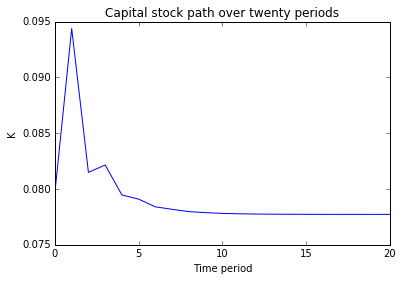

In [20]:
plt.plot(K,)
plt.title("Capital stock path over twenty periods")
plt.xlabel("Time period")
plt.ylabel("K")
plt.savefig('K_path.png')
plt.show()

It took the economy approximately 14 periods to reach steady state equilibrium.

In [22]:
print abs(K-K_bar)

[  1.97861204e-03   1.66516823e-02   3.76855734e-03   4.42647858e-03
   1.74271917e-03   1.36817372e-03   6.77369505e-04   4.54546785e-04
   2.49011393e-04   1.56204500e-04   8.95282163e-05   5.45133705e-05
   3.18815458e-05   1.91566151e-05   1.13050424e-05   6.75264807e-06
   4.00106245e-06   2.38352523e-06   1.41476885e-06   8.41268728e-07
   4.87740260e-07]
